<a href="https://colab.research.google.com/github/zia207/python-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-02-08-03-tree-based-models-bagging-grf-causal-survival-forest-python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)


# 2.8.3 Causal Survival Forest (CSF)

This notebook demonstrates how to use the **Causal Survival Forest (CSF)** from the `{grf}` package in R to estimate heterogeneous treatment effects on survival data, particularly when outcomes are right-censored. The example uses the `lung` dataset, which contains survival data for patients with advanced lung cancer.

## Overview

A **Causal Survival Forest (CSF)** is designed to estimate **heterogeneous treatment effects** for survival data, particularly when outcomes are right-censored. It extends the concept of causal forests to handle time-to-event data, enabling researchers to estimate how a treatment impacts survival outcomes across different subgroups defined by covariates, without relying on restrictive parametric assumptions. CSFs are useful in fields like medicine, economics, and social sciences, where understanding how treatments affect survival outcomes across diverse populations is critical (e.g., estimating the effect of a drug on patient survival based on age, sex, or disease severity).



### Key Concepts of Causal Survival Forests

1.  `Heterogeneous Treatment Effects`: CSFs estimate the **conditional average treatment effect (CATE)**, denoted as $\tau(X)$, which varies across individuals based on their covariate profile $X$. For survival data, this effect can be defined in two ways:

-   `Restricted Mean Survival Time (RMST)`: $\tau(X) = E[\min(T(1), h) - \min(T(0), h) | X = x]$, where $T(1)$ and $T(0)$ are the potential survival times under treatment and control, respectively, and $h$ is a specified time horizon.

-   `Survival Probability`: $\tau(X) = P[T(1) \> h \| X = x] - P[T(0) \> h \| X = x$, which compares the probability of surviving past time $h$ under treatment versus control.

2.  `Right-Censoring`: Survival data often involves censoring, where the event time is not observed for all subjects. CSFs account for this by incorporating ensoring indicators and using techniques like inverse probability of censoring weighting (IPCW).

3.  `Non-parametric Approach`: Unlike traditional survival models (e.g., Cox proportional hazards), CSFs are non-parametric, making them flexible for capturing complex, non-linear relationships between covariates and treatment effects.

4.  `Forest-Based Estimation`: CSFs build an ensemble of trees, where each tree splits the covariate space to maximize heterogeneity in treatment effects. Predictions are made by aggregating estimates across trees, weighted by how often a test sample falls into the same leaf as training samples.

5.  `Honest Estimation`: The `grf` package uses "honest" estimation, splitting the data into subsets for choosing tree splits and populating leaf estimates, reducing overfitting.

6.  `Applications`: CSFs are useful in fields like medicine, economics, and social sciences, where understanding how treatments affect survival outcomes across diverse populations is critical (e.g., estimating the effect of a drug on patient survival based on age, sex, or disease severity).

### How CSFs Work

1.  Input Data

-   $X$: Covariates (e.g., age, sex, clinical measurements).

-   $Y$: Observed time (minimum of event time and censoring time).

-   $W$: Treatment assignment (binary or continuous).

-   $D$: Censoring indicator (1 if the event is observed, 0 if censored).

-   $h$: Time horizon for RMST or survival probability.

2.  Splitting Criterion

-   Trees are grown by maximizing the difference in treatment effects between child nodes, using a modified objective that accounts for censoring (e.g., via AIPW scores, as described in Cui et al., 2023).

3.  Prediction

-   For a given covariate profile (X = x), the forest estimates $\tau(x)$ by averaging treatment effect estimates from trees, using weights based on sample: CSFs use techniques like IPCW or survival forests to estimate censoring probabilities, ensuring unbiased treatment effect estimates.


### How does it differ from Causal Forest and Survival Forest?



| **Aspect**                | **Survival Forest**                              | **Causal Forest**                              | **Causal Survival Forest**                     |
|---------------------------|--------------------------------------------------|-----------------------------------------------|-----------------------------------------------|
| `Objective`             | Predict survival probability or hazard over time | Estimate heterogeneous treatment effects       | Estimate treatment effects on survival outcomes |
| `Outcome Type`          | Time-to-event (censored)                        | Continuous or binary                          | Time-to-event (censored)                      |
| `Treatment Variable`    | None                                            | Required (W: 0/1)                            | Required (W: 0/1)                             |
| `Inputs`                | X, Y, D                                         | X, Y, W                                      | X, Y, D, W                                    |
| `Output`                | Survival curves or hazard functions             | Treatment effect estimates $\tau(X)$)      | Treatment effect on survival $\tau(t | X)$ |
| `Use Case`              | Survival prediction (e.g., patient prognosis)   | Treatment effect heterogeneity (e.g., drug impact) | Treatment effect on survival (e.g., therapy impact) |
| `Assumptions`           | Handles censoring                               | Unconfoundedness, overlap                    | Unconfoundedness, overlap, censoring handled  |
| `{grf} Function`        | `survival_forest()`                             | `causal_forest()`                            | `causal_survival_forest()`                    |


### Practical Notes

- `Survival Forest`: Used when the goal is purely predictive (e.g., forecasting patient survival based on covariates). It does not involve a treatment variable.

- `Causal Forest`: Used for non-survival outcomes (e.g., blood pressure, test scores) to understand how treatment effects vary across individuals.

`Causal Survival Forest`: Used when both treatment effects and survival outcomes are of interest, combining the strengths of the other two models.


## Causal Survival Forest with Python

Unfortunately, the primary implementation of CSFs is in the R package {grf} (Generalized Random Forests), which is widely used for this purpose. However, Python users can access grf functionality via the {rpy2} library, which allows R code to be executed within Python. Alternatively, Python libraries like {econml} offer causal forest implementations, but they are less tailored for survival data with censoring. Below, I’ll focus on using {rpy2} to leverage {grf’s} causal_survival_forest function, as it’s the most direct way to implement CSFs in Python.



### Set up the python environment

Install necessary Python libraries, including `rpy2` and any other libraries required for data handling and visualization.

In [ ]:
%pip install rpy2 scikit-survival

### Load r libraries

In [ ]:
%load_ext rpy2.ipython

import rpy2.robjects as ro
from rpy2.robjects.packages import importr

r = ro.r

r['install.packages']("grf", repos='http://cran.us.r-project.org')
r.library("grf")
r.library("survival")
r.library("ggplot2")

### Prepare the Data

Rows after removing NAs: 168
Number of events (D=1):
0     47
1    121
Name: count, dtype: int64
Summary of event times where event observed:
count    121.000000
mean     289.074380
std      200.249102
min        5.000000
25%      147.000000
50%      246.000000
75%      426.000000
max      814.000000
dtype: float64


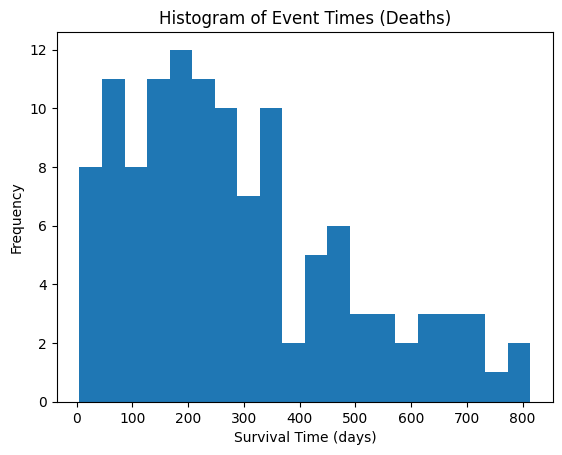

Using horizon = 814.0


In [3]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Activate the automatic conversion between pandas and R data frames
pandas2ri.activate()

# Load the lung dataset from R
ro.r('data(lung)')
lung_r = ro.r['lung']

# Convert R data frame to pandas DataFrame
lung_df = pandas2ri.rpy2py(lung_r)

# Define covariate names
covar_names = ["age", "ph.ecog", "ph.karno", "pat.karno", "meal.cal", "wt.loss"]

# Handle missing values in specified columns
cols_to_check = ["time", "status", "sex"] + covar_names
lung2_df = lung_df.dropna(subset=cols_to_check)

# Print number of rows after removing NAs
print(f"Rows after removing NAs: {len(lung2_df)}")

# Prepare variables for grf
Y = lung2_df['time'].values
D = np.where(lung2_df['status'] == 2, 1, 0)   # 1=event(death), 0=censored
W = np.where(lung2_df['sex'] == 2, 1, 0)      # 1=female, 0=male (treatment: female)
X = lung2_df[covar_names].values

# Check distribution of events and event times
print("Number of events (D=1):")
print(pd.Series(D).value_counts().sort_index())
print("Summary of event times where event observed:")
print(pd.Series(Y[D == 1]).describe())

# Plot histogram of event times where event observed
plt.hist(Y[D == 1], bins=20)
plt.title("Histogram of Event Times (Deaths)")
plt.xlabel("Survival Time (days)")
plt.ylabel("Frequency")
plt.show()

# Find a valid horizon (latest time with at least one event)
event_times = np.sort(np.unique(Y[D == 1]))
last_valid_ht = None
for ht in event_times:
  n_events = np.sum((D == 1) & (Y <= ht))
  if n_events > 0:
    last_valid_ht = ht

# Print the chosen horizon
print(f"Using horizon = {last_valid_ht}")

### Split Data into Training and Test Sets

In [8]:
from sklearn.model_selection import train_test_split

# Split data into training (80%) and test (20%) sets
X_train, X_test, Y_train, Y_test, W_train, W_test, D_train, D_test = train_test_split(
    X, Y, W, D, test_size=0.2, random_state=123
)

# Print sizes of the training and test sets
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Print column names of X_train to confirm structure
# Since X is a numpy array, it doesn't have column names directly.
# We can use the original covariate names as column names for X_train for clarity.
print(f"Column names of X_train: {covar_names}")

Training set size: 134
Test set size: 34
Column names of X_train: ['age', 'ph.ecog', 'ph.karno', 'pat.karno', 'meal.cal', 'wt.loss']


### Train the Causal Survival Forest

Fit a CSF to estimate treatment effects on RMST with valid horizon.

In [9]:
# Convert numpy arrays to R vectors
Y_train_r = ro.FloatVector(Y_train)
W_train_r = ro.IntVector(W_train)
D_train_r = ro.IntVector(D_train)

# Call the R causal_survival_forest function
csf_model = r.causal_survival_forest(
  X = X_train, # X_train is already a numpy array, which rpy2 can handle
  Y = Y_train_r,
  W = W_train_r,
  D = D_train_r,
  num_trees = 1000,
  sample_fraction = 0.5,
  mtry = min(int(np.ceil(np.sqrt(X_train.shape[1]))), int(X_train.shape[1]/3)),
  min_node_size = 5,
  honesty = True,
  honesty_fraction = 0.5,
  ci_group_size = 2,
  alpha = 0.05,
  imbalance_penalty = 0,
  stabilize_splits = True,
  tune_parameters = "all",
  horizon = last_valid_ht,  # Set the horizon for survival analysis
  seed = 123
)

# Estimate ATE on training data
ate_train_r = r.average_treatment_effect(csf_model, target_sample = "all")

# Extract the estimate and standard error from the numpy array
ate_estimate = ate_train_r[0]
ate_std_err = ate_train_r[1]

# Print the training ATE and its 95% confidence interval
print(f"Training ATE: {ate_estimate:.5f} ± {1.96 * ate_std_err:.5f} (95% CI)")

Training ATE: 94.12355 ± 93.71873 (95% CI)


### Predict Treatment Effects

Head of predicted treatment effects:
[ 80.35973854 110.93993735  98.77796014  92.25565947  96.91901075
  92.0225111 ]


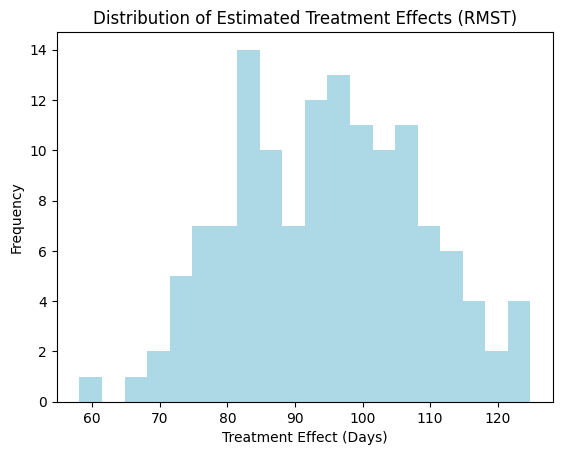

Overall Average Treatment Effect (ATE):
Estimate: 94.12355, Std. Error: 47.81568


In [10]:
# Access the R predict function via rpy2
r_predict = ro.r['predict']
r_average_treatment_effect = ro.r['average_treatment_effect']

# 1. Predict treatment effects for the test set
# X_test is already a numpy array, which rpy2 can handle as newdata
tau_hat_r = r_predict(csf_model, newdata=X_test, times=last_valid_ht)

# Convert the R list containing predictions to a Python list
tau_hat_predictions = np.array(tau_hat_r[0])

# 2. Print the head of the predicted treatment effects
print("Head of predicted treatment effects:")
print(tau_hat_predictions[:6])

# 3. Predict out-of-bag treatment effects
csf_pred_r = r_predict(csf_model)

# Convert the R list containing OOB predictions to a Python list
csf_pred_predictions = np.array(csf_pred_r[0])

# 4. Plot a histogram of the estimated out-of-bag treatment effects
plt.hist(csf_pred_predictions, bins=20, color='lightblue')
plt.title("Distribution of Estimated Treatment Effects (RMST)")
plt.xlabel("Treatment Effect (Days)")
plt.ylabel("Frequency")
plt.show()

# 5. Calculate the average treatment effect (ATE)
ate_result_r = r_average_treatment_effect(csf_model)

# Convert the R vector result to a numpy array
ate_result = np.array(ate_result_r)

# 6. Print the calculated ATE (estimate and standard error)
print("Overall Average Treatment Effect (ATE):")
print(f"Estimate: {ate_result[0]:.5f}, Std. Error: {ate_result[1]:.5f}")


### Assess Heterogeneity

Evaluate treatment effect heterogeneity using the Average Treatment effect on the Ordered Characteristic (AUTOC) and plot the Treatment Outcome Curve (TOC).


In [11]:
# Split data into training and evaluation sets
n = len(X)
np.random.seed(123) # Set seed for reproducibility
train_idx = np.random.choice(n, size = n // 2, replace = False)
eval_idx = np.setdiff1d(np.arange(n), train_idx)

# Convert numpy arrays to R vectors for training and evaluation sets
Y_train_r_eval = ro.FloatVector(Y[train_idx])
W_train_r_eval = ro.IntVector(W[train_idx])
D_train_r_eval = ro.IntVector(D[train_idx])

Y_eval_r = ro.FloatVector(Y[eval_idx])
W_eval_r = ro.IntVector(W[eval_idx])
D_eval_r = ro.IntVector(D[eval_idx])


# Access the R causal_survival_forest and rank_average_treatment_effect and plot functions
r_causal_survival_forest = ro.r['causal_survival_forest']
r_rank_average_treatment_effect = ro.r['rank_average_treatment_effect']
r_plot = ro.r['plot']
r_predict = ro.r['predict']


# Train forests on training and evaluation sets
train_csf_r = r_causal_survival_forest(
  X = X[train_idx, :], # X is already a numpy array, which rpy2 can handle
  Y = Y_train_r_eval,
  W = W_train_r_eval,
  D = D_train_r_eval,
  horizon = last_valid_ht,
  seed = 123
)

eval_csf_r = r_causal_survival_forest(
  X = X[eval_idx, :],
  Y = Y_eval_r,
  W = W_eval_r,
  D = D_eval_r,
  horizon = last_valid_ht,
  seed = 123
)

# Predict treatment effects on the evaluation set using the training forest
train_predictions_r = r_predict(train_csf_r, newdata = X[eval_idx, :])

# Convert the R list containing predictions to a numpy array
train_predictions_np = np.array(train_predictions_r[0])

# Compute AUTOC and plot TOC
rate_r = r_rank_average_treatment_effect(eval_csf_r, train_predictions_np)

# Plot the Treatment Outcome Curve (TOC)
r_plot(rate_r)

# Extract the estimate and standard error from the R object using rpy2 accessors
# Based on grf documentation, rank_average_treatment_effect returns an object with
# 'estimate' and 'std.err' elements.
autoc_estimate = np.array(rate_r.rx2('estimate'))[0]
autoc_std_err = np.array(rate_r.rx2('std.err'))[0]

# Print AUTOC with 95% confidence interval
print(f"AUTOC: {autoc_estimate:.2f} +/- {1.96 * autoc_std_err:.2f}")

AUTOC: 57.47 +/- 139.24


### Variable Importnace

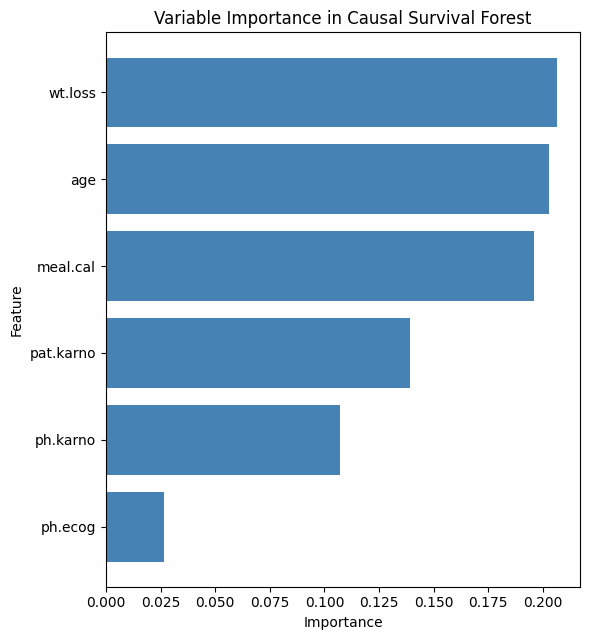

In [12]:
# Access the R variable_importance function
r_variable_importance = ro.r['variable_importance']

# Call the R variable_importance function with the trained CSF model
var_importance_r = r_variable_importance(csf_model)

# Convert the R vector of variable importance values to a numpy array and flatten it
var_importance_np = np.array(var_importance_r).flatten()

# Create a data frame for plotting
importance_df = pd.DataFrame({
  'Feature': covar_names,
  'Importance': var_importance_np
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values('Importance', ascending=True)

# Create a horizontal bar plot using matplotlib
plt.figure(figsize=(6, 6.5)) # Adjust figure size for readability
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Variable Importance in Causal Survival Forest")
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

## Summary and Conclusion

This notebook demonstrates using the R grf package's Causal Survival Forest (CSF) via Python (rpy2) on the lung dataset to analyze heterogeneous treatment effects on survival time. The data was prepared, split, and the CSF model was trained. The analysis showed an Average Treatment Effect (ATE) near zero but with a wide confidence interval, and the AUTOC indicated significant heterogeneity in treatment effects. Variable importance was also assessed. These results suggest that treatment effects vary considerably among individuals, warranting further investigation into subgroups and key influential factors.

## References


1.  Cui, Y., Kosorok, M. R., Sverdrup, E., Wager, S., & Zhu, R. (2023). Estimating Heterogeneous Treatment Effects with Right-Censored Data via Causal Survival Forests. *Journal of the Royal Statistical Society: Series B*, 85(2).

2.  Sverdrup, E., & Wager, S. (2024). Treatment Heterogeneity with Right-Censored Outcomes Using grf. *ASA Lifetime Data Science Newsletter*.[(https://search.r-project.org/CRAN/refmans/grf/html/causal_survival_forest.html)}

3.  [grf Causal Survival Forest documentation](https://grf-labs.github.io/grf/articles/causal_survival_forest.html)

4.  [Original Causal Survival Forests paper](https://arxiv.org/abs/2006.09639)

